# Read and Explore Data

In [1]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
from typing import Union, Tuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from task1.retrieval_system import RetrievalSystem, SongInfo
from task1.similarity_measure import (
    cosine_similarity,
    dot_product,
    manhattan_distance,
    euclidean_distance,
    random_similarity,
)
from utils import read, embed_and_merge

In [3]:
# basic song information from task 1
df = read("information", 0)
df

,id,artist,song,album_name
0,01Yfj2T3YTwJ1Yfy,We As Human,Take The Bullets Away (feat. Lacey Sturm),We As Human
1,01gyRHLquwXDlhkO,The Notorious B.I.G.,Somebody's Gotta Die,Life After Death (Remastered Edition)
2,01rMxQv6vhyE1oQX,Against the Current,Chasing Ghosts,In Our Bones
3,02RGE9FNH65RtMS7,Barthezz,Infected,Trance - The Early Years (1997-2002)
4,02ZnlCGZEbkfCDxo,Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te
...,...,...,...,...
10090,zyzILCQvVeUFIINi,Crowded House,When You Come,Temple Of Low Men
10091,zzgS4ZqyswamEWNj,Britney Spears,My Only Wish (This Year),Platinum Christmas
10092,zzoFYDMlqU1X2zz1,Thundercat,DUI,Drunk
10093,zzpkRCGA5ud8q4mv,Otis Redding,Rock Me Baby,Otis Blue


In [4]:
# add genre information for metric calculation
genres = read("genres", 0)
# convert genre to actual list via eval
genres["genre"] = genres["genre"].apply(eval).apply(set)
df = df.merge(genres, on="id", how="left")

We load the following features:
- MFCCs in BoW form,
- Spectral BLFs,
- 256-dimensional i-vectors,
- 1024-dimensional i-vectors,
- DNN-based features (musicnn).

In [5]:
for feature in ["mfcc_bow", "blf_spectral", "ivec256", "ivec1024", "musicnn"]:
    stats = read(feature, 0)
    df = embed_and_merge(df, stats, feature)

... and also those from the previous assignment:

In [6]:
for text_feature in ["lyrics_bert", "lyrics_word2vec", "lyrics_tf-idf"]:
    stats = read(text_feature, 0)
    df = embed_and_merge(df, stats, text_feature.split("_")[1])

In [7]:
df.isna().sum()

id              0
artist          0
song            0
album_name      0
genre           1
mfcc_bow        1
blf_spectral    1
ivec256         1
ivec1024        1
musicnn         1
bert            0
word2vec        0
tf-idf          0
dtype: int64

In [8]:
df[df.isna().any(axis=1)]

,id,artist,song,album_name,genre,mfcc_bow,blf_spectral,ivec256,ivec1024,musicnn,bert,word2vec,tf-idf
5,03Oc9WeMEmyLLQbj,Shakira,Costume Makes the Clown,"Oral Fixation, Vol. 2 (Expanded Edition)",NaN,NaN,NaN,NaN,NaN,NaN,"[0.042631160467863, 0.0509439371526241, -0.026...","[0.0173026816431956, 0.0238044851088488, 0.013...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
df["mfcc_bow"].values[1].shape

(500,)

In [10]:
# data for task 2 does not include the item with id "03Oc9WeMEmyLLQbj" = row 5
df = df.drop(5)
df = df.reset_index()

# Define retrieval systems

## From Task 1 (text-based)

In [11]:
rs_random = RetrievalSystem(
    df=df,
    sim_metric=random_similarity,
)

In [12]:
rs_cos_tdidf = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="tf-idf",
)

In [13]:
rs_cos_bert = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="bert",
)

In [14]:
rs_dot_w2v = RetrievalSystem(
    df=df,
    sim_metric=dot_product,
    sim_feature="word2vec",
)

## From Task 2 (audio-based; new!)

In [15]:
rs_cos_mfcc = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="mfcc_bow",
)

In [16]:
rs_cos_blf = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="blf_spectral",
)

In [17]:
rs_cos_ivec256 = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="ivec256",
)

In [18]:
rs_cos_dnn = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="musicnn",
)

In [19]:
# create pd dataframe consisting of all retrieval systems, with metric and feature
rs = pd.DataFrame(
    [
        ["random", "random", rs_random],
        ["cosine", "tf-idf", rs_cos_tdidf],
        ["cosine", "bert", rs_cos_bert],
        ["dot", "word2vec", rs_dot_w2v],
        ["cosine", "mfcc_bow", rs_cos_mfcc],
        ["cosine", "blf_spectral", rs_cos_blf],
        ["cosine", "ivec256", rs_cos_ivec256],
        ["cosine", "musicnn", rs_cos_dnn],
    ],
    columns=["metric", "feature", "rs_object"],
)

In [20]:
rs

,metric,feature,rs_object
0,random,random,<task1.retrieval_system.RetrievalSystem object...
1,cosine,tf-idf,<task1.retrieval_system.RetrievalSystem object...
2,cosine,bert,<task1.retrieval_system.RetrievalSystem object...
3,dot,word2vec,<task1.retrieval_system.RetrievalSystem object...
4,cosine,mfcc_bow,<task1.retrieval_system.RetrievalSystem object...
5,cosine,blf_spectral,<task1.retrieval_system.RetrievalSystem object...
6,cosine,ivec256,<task1.retrieval_system.RetrievalSystem object...
7,cosine,musicnn,<task1.retrieval_system.RetrievalSystem object...


# Evaluation Criteria

For the sake of completeness, we also show how we can calculate precision and recall independently for a given single query.

## Precision@k & Recall@k

In [21]:
def precision_at_k_single(
    query: pd.Series, retrieved_tracks: pd.DataFrame, k: int
) -> float:
    """Precision at k for a single query song.

    Args:
        query (pd.Series): Query song.
        retrieved_tracks (pd.DataFrame): Retrieved tracks.
        k (int): Number of retrieved tracks to consider.

    Raises:
        ValueError: k must be smaller than the number of retrieved tracks.

    Returns:
        float: Precision at k.

    """
    # Filter the retrieved tracks to top k
    retrieved_tracks = retrieved_tracks.head(k)

    if k > len(retrieved_tracks):
        raise ValueError(
            f"k must be smaller than the number of retrieved tracks ({len(retrieved_tracks)})"
        )

    relevant_items_retrieved = sum(
        1
        for _, track in retrieved_tracks.head(k).iterrows()
        if query["genre"] & track["genre"]
    )
    return relevant_items_retrieved / k

In [22]:
def recall_at_k_single(
    query: pd.Series, retrieved_tracks: pd.DataFrame, k: int
) -> float:
    """Recall at k for a single query song.
    Note that we normalize by the *total* number of relevant items in the dataset.
    Args:
        query (pd.Series): Query song.
        retrieved_tracks (pd.DataFrame): Retrieved tracks.
        k (int): Number of retrieved tracks to consider.
    Raises:
        ValueError: k must be smaller than the number of retrieved tracks.

    Returns:
        float: Recall at k.
    """
    # Filter the retrieved tracks to top k
    retrieved_tracks = retrieved_tracks.head(k)

    if k > len(retrieved_tracks):
        raise ValueError(
            f"k must be smaller than the number of retrieved tracks ({len(retrieved_tracks)})"
        )

    relevant_items_retrieved = sum(
        1
        for _, track in retrieved_tracks.head(k).iterrows()
        if query["genre"] & track["genre"]
    )

    relevant_items = sum(
        1 for _, track in df.iterrows() if set(query["genre"]) & set(track["genre"])
    )
    return relevant_items_retrieved / relevant_items

In [23]:
sample_song = SongInfo(title="Zombie", artist="The Cranberries")
# query most be a pd.Series --> convert here
sample_query = df[
    (df["song"] == sample_song.title) & (df["artist"] == sample_song.artist)
].iloc[0]

In [24]:
sample_query.genre

{'alternative rock',
 'celtic',
 'celtic rock',
 'classic rock',
 'grunge',
 'hard rock',
 'indie rock',
 'irish rock',
 'metal',
 'pop',
 'pop rock',
 'post grunge',
 'rock',
 'soft rock'}

In [25]:
results = rs_cos_dnn.retrieve(sample_song, 10)

In [26]:
results

,index,id,artist,song,album_name,genre,mfcc_bow,blf_spectral,ivec256,ivec1024,musicnn,bert,word2vec,similarity
0,790,4glaLmaXFAdOw5b2,Kristen Barry,Ordinary Life,Cruel Intentions,"{soundtrack, singer songwriter, soft rock, pop...","[0.7781513000000001, 0.0, 2.3242824, 0.0, 1.17...","[-0.0281731, -0.019438, -0.017372, -0.0138386,...","[0.9454425573349, 1.2708547115325928, 0.325989...","[-0.0687375515699386, -1.0911340713500977, -0....","[0.4182759, 0.007046508, 0.18775995, 0.0074302...","[-0.0004561332461889, 0.0145782874897122, -0.0...","[0.0201837079373767, 0.0221617151968885, 0.016...",0.987132
1,4469,RQJ8biiC0Ed7MKyY,Shakira,Sale el Sol,Sale el Sol,"{folk, alternative rock, singer songwriter, la...","[1.7160033, 0.0, 2.667453, 0.0, 1.1139433, 0.0...","[-0.0238793, -0.0183009, -0.0153329, -0.013102...","[1.8669582605361936, 1.892633914947509, -1.045...","[1.905163645744324, -1.7262425422668457, 0.853...","[0.36982688, 0.009932475, 0.18211164, 0.019003...","[0.0123901953920722, 0.0618347860872745, 0.001...","[0.0206834120802038, 0.0080418127259084, 0.011...",0.985367
2,9954,z14vWV00cAGeBT9P,Céu,Lenda,CéU,"{brazilian jazz, rap, singer songwriter, latin...","[1.3222193000000002, 0.0, 2.146128, 0.0, 2.096...","[-0.0258737, -0.0207687, -0.0182119, -0.015643...","[1.7744811773300169, 1.3900917768478394, -0.28...","[0.2054368406534195, -1.1734609603881836, 0.06...","[0.2876089, 0.00694283, 0.09736701, 0.02208063...","[0.0605621598660945, 0.0248984489589929, -0.02...","[0.0354904266487643, 0.009812428646477, 0.0021...",0.985336
3,386,29oADILKxhOHvgvQ,Lucy Dacus,Troublemaker Doppelgänger,No Burden,"{indie folk, indie rock}","[1.7923917, 0.0, 2.0293837, 0.0, 2.6374898, 0....","[-0.0402956, -0.034032, -0.031251, -0.029338, ...","[0.5575369000434875, 1.3157860040664673, 0.573...","[0.6444730758666992, -1.242782711982727, -0.70...","[0.32060316, 0.0129062785, 0.13242425, 0.02154...","[0.0196989458054304, 0.0582268238067626, 0.001...","[0.0193930917207513, 0.0224321799395334, 0.008...",0.984114
4,7650,lBbxNiUrl7pF1H4c,Kadebostany,Castle in the Snow,Pop Collection,"{pop, rock}","[0.7781513000000001, 0.0, 1.462398, 0.0, 1.301...","[-0.0240562, -0.0197435, -0.0169551, -0.013990...","[1.3591880798339844, 0.6209864020347595, 0.309...","[1.3591336011886597, -0.4918332695960999, -0.4...","[0.27542847, 0.0085207485, 0.17537211, 0.01616...","[-0.0136576881632208, 0.0381329879164695, 0.00...","[0.0169709496347023, 0.0083717900892431, -0.02...",0.983854
5,1584,9SUQfSsDIBOh3QSV,Priscilla Ahn,Masters In China,A Good Day,"{singer songwriter, folk, soul}","[1.50515, 0.0, 1.462398, 0.0, 2.30103, 0.0, 1....","[-0.0191349, -0.0124968, -0.0088663, -0.006168...","[2.129467725753784, 1.0896250009536743, 0.6828...","[2.1317338943481445, -0.8425770401954651, -0.9...","[0.42481366, 0.0026636927, 0.19867267, 0.00749...","[0.0182842426002025, 0.0133442115038633, -0.02...","[0.0165479896808019, 0.0139839527770303, 0.010...",0.983130
6,9669,xEbmBtcR1wQcnk3y,Julieta Venegas,Oleada,Si,"{mexican pop, latin, rock en espanol, pop, lat...","[2.3873900000000003, 0.0, 2.469822, 0.0, 2.176...","[-0.0160536, -0.0104534, -0.00665913, -0.00423...","[1.5788124799728394, 1.6625230312347412, 0.228...","[1.014309287071228, -1.466999053955078, -0.471...","[0.44143254, 0.0077322265, 0.21047759, 0.00914...","[0.0002455622889101, 0.0310425776988267, -0.01...","[0.0073746261101526, 0.0089111965646346, 0.022...",0.982718
7,1147,6vbf44Iw7PzRxUWH,Taylor Swift,The Best Day,Fearless,"{country pop, singer songwriter, pop rock, pop...","[2.1760912, 0.0, 2.409933, 0.0, 2.348304700000...","[-0.0254457, -0.0206701, -0.0167254, -0.014913...","[-0.5983439087867737, 1.6506197452545166, -0.1...","[-0.1132917702198028, -1.7878351211547852, 0.0...","[0.4190213, 0.006415901, 0.16974963, 0.0041287...","[0.0102109359577298, 0.0159489773213863, -0.01...","[0.0060818882261895, 0.0110121118431694, 0.005...",0.982597
8,9008,tJHK6mqbsr1ebi7Z,Shania Twain,Dance With The One That Brought You,Shania Twain,{countr

In [27]:
for res in results.genre:
    if sample_query.genre & res:
        print("match:", sample_query.genre & res)

match: {'soft rock', 'pop', 'indie rock'}
match: {'alternative rock', 'soft rock', 'pop rock', 'pop', 'rock'}
match: {'indie rock'}
match: {'pop', 'rock'}
match: {'pop', 'rock'}
match: {'pop rock', 'pop'}
match: {'pop'}


In [28]:
precision_at_k_single(sample_query, results, 10)

0.7

In [29]:
recall_at_k_single(sample_query, results, 10)

0.000902178115736564

However, we can simplify & speed up the calculation by:
- Creating a genre overlap matrix. Since we consider a track to be relevant if query and retrieved track have one or more genre in common, we can pre-calculate these for speed. This is especially helpful for the recall, as we have to get the full matches for every query (create_genre_overlap_matrix).
- Combine precision and recall into a single function (combined_rec_prec_at_k_single).

In [30]:
def create_genre_overlap_matrix(songs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create an optimized DataFrame representing the genre overlap between each pair of songs.
    Args:
        songs_df (pd.DataFrame): DataFrame containing the songs.

    Returns:
        pd.DataFrame: DataFrame with genre overlap between each pair of songs.
    """
    # Create a dictionary for faster access
    genre_dict = songs_df.set_index("id")["genre"].to_dict()

    # init empty matrix
    overlap_matrix = pd.DataFrame(
        index=songs_df["id"], columns=songs_df["id"], dtype=bool
    )

    for song_id, genres in genre_dict.items():
        overlap_matrix.loc[song_id] = [
            bool(genres & genre_dict[other_id]) for other_id in songs_df["id"]
        ]

    return overlap_matrix

In [31]:
genre_overlap_matrix = create_genre_overlap_matrix(df)
genre_overlap_matrix.head(10)

id,01Yfj2T3YTwJ1Yfy,01gyRHLquwXDlhkO,01rMxQv6vhyE1oQX,02RGE9FNH65RtMS7,02ZnlCGZEbkfCDxo,04OjszRi9rC5BlHC,04iitW3ffa0mhpx3,04xUDjAYC14jsHyH,06HvNTU9M9lnH71I,06L9OJ5nRqKnO2q9,...,zxI0u8m0EPvVhNeD,zxYtSeZzEVgPczJz,zxlnGZoud2KCmSaw,zyxOCKcXX1RmWpm0,zyz0UbYN4n9rHXex,zyzILCQvVeUFIINi,zzgS4ZqyswamEWNj,zzoFYDMlqU1X2zz1,zzpkRCGA5ud8q4mv,zzx8CWdM7qkxKQpC
id,,,,,,,,,,,,,,,,,,,,,
01Yfj2T3YTwJ1Yfy,True,False,True,False,False,True,False,False,False,False,...,True,True,True,True,False,True,True,False,True,True
01gyRHLquwXDlhkO,False,True,False,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
01rMxQv6vhyE1oQX,True,False,True,False,False,True,False,False,False,False,...,True,True,True,True,False,True,True,False,True,True
02RGE9FNH65RtMS7,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
02ZnlCGZEbkfCDxo,False,False,False,False,True,True,True,False,True,False,...,True,False,False,True,True,True,True,False,False,False
04OjszRi9rC5BlHC,True,False,True,False,True,True,True,False,False,False,...,True,True,True,True,True,True,True,False,True,True
04iitW3ffa0mhpx3,False,True,False,False,True,True,True,False,False,False,...,True,False,True,True,True,True,True,False,True,True
04xUDjAYC14jsHyH,False,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,True
06HvNTU9M9lnH71I,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,False


In [32]:
def combined_rec_prec_at_k_single(
    query_id: str, retrieved_tracks: pd.DataFrame, k: int, overlap_matrix: pd.DataFrame
) -> Tuple[float, float]:
    """Combined precision and recall at k for a single query song.

    Args:
        query_id (str): Query song id.
        retrieved_tracks (pd.DataFrame): The retrieved tracks of an RS.
        k (int): Number of retrieved tracks to consider.
        overlap_matrix (pd.DataFrame): The genre overlap matrix.

    Raises:
        ValueError: k must be smaller than or equal to the number of retrieved tracks.

    Returns:
        Tuple[float, float]: Precision and recall at k.
    """
    if k > len(retrieved_tracks):
        raise ValueError(
            f"k must be smaller than or equal to the number of retrieved tracks ({len(retrieved_tracks)})"
        )

    # Filter the retrieved tracks to top k
    retrieved_tracks = retrieved_tracks.head(k)

    # Count relevant items in top k using the overlap matrix
    relevant_items_retrieved = overlap_matrix.loc[
        query_id, retrieved_tracks["id"]
    ].sum()

    # Count total relevant items in the dataset using the overlap matrix
    relevant_items_total = overlap_matrix.loc[query_id].sum()

    precision = relevant_items_retrieved / k
    recall = (
        relevant_items_retrieved / relevant_items_total
        if relevant_items_total > 0
        else 0
    )

    return precision, recall

In [33]:
precision, recall = combined_rec_prec_at_k_single(
    sample_query["id"], rs_cos_dnn.retrieve(sample_song, 10), 10, genre_overlap_matrix
)
precision, recall

(0.7, 0.000902178115736564)

We can see that we get the same results.

## nDCG@10

In [34]:
def sorensen_dice_genres(genre1: set, genre2: set) -> float:
    """Calculate the Sorensen-Dice coefficient for two sets of genres.
    Args:
        genre1 (set): First set of genres.
        genre2 (set): Second set of genres.
    Returns:
        float: Sorensen-Dice coefficient.
    """
    return 2 * len(genre1 & genre2) / (len(genre1) + len(genre2))

In [35]:
def calculate_dcg(
    sample_query: pd.Series, retrieved_tracks: pd.DataFrame, k: int
) -> float:
    """Calculate DCG for a single query song.
    Args:
        sample_query (pd.Series): Query song.
        retrieved_tracks (pd.DataFrame): Retrieved tracks.
        k (int): Number of retrieved tracks to consider.
    Returns:
        float: DCG@k
    """
    # Vectorized calculation of relevance scores
    relevance_scores = retrieved_tracks["genre"].apply(
        lambda x: sorensen_dice_genres(sample_query["genre"], x)
    )
    top_k_scores = relevance_scores.head(k).values

    denominators = np.log2(
        np.arange(2, k + 1)
    )  # Starts from 2 since log2(1) is 0 and it's used for the first item
    return top_k_scores[0] + sum(top_k_scores[1:] / denominators)

In [36]:
# test
calculate_dcg(sample_query, results, 10)

0.9926746644813018

In [37]:
def calculate_idcg(sample_query: pd.Series, k: int) -> float:
    """Calculate IDCG for a single query song.
    Args:
        sample_query (pd.Series): Query song.
        k (int): Number of retrieved tracks to consider.

    Returns:
        float: IDCG@k
    """
    # Vectorized calculation of relevance scores
    relevance_scores = df["genre"].apply(
        lambda x: sorensen_dice_genres(sample_query["genre"], x)
    )
    # sort and take top k
    sorted_scores = relevance_scores.sort_values(ascending=False).head(k).values

    # normalize by log2 of rank
    denominators = np.log2(np.arange(2, k + 1))
    return sorted_scores[0] + sum(sorted_scores[1:] / denominators)

In [38]:
calculate_idcg(sample_query, 10)

3.9121303227676525

In [39]:
def ndcg_at_k_single(
    sample_query: pd.Series, retrieved_tracks: pd.DataFrame, k: int
) -> float:
    """NDCG@k for a single query song.
    Args:
        sample_query (pd.Series): Query song.
        retrieved_tracks (pd.DataFrame): Retrieved tracks.
        k (int): Number of retrieved tracks to consider.
    Returns:
        float: NDCG@k
    """
    if k > len(retrieved_tracks):
        raise ValueError(
            f"k must be smaller than the number of retrieved tracks ({len(retrieved_tracks)})"
        )

    retrieved_tracks = retrieved_tracks.head(k)
    return calculate_dcg(sample_query, retrieved_tracks, k) / calculate_idcg(
        sample_query, k
    )

In [40]:
ndcg_at_k_single(sample_query, results, 10)

0.25374273927025776

## Beyond Accuracy
Genre Coverage and Diversity

In [41]:
unique_genres = set()
for g in genres["genre"]:
    unique_genres.update(g)

genre_2_index = {g: i for i, g in enumerate(unique_genres)}
id_2_genres = genres.set_index("id")["genre"].to_dict()

print(f"number of total genres={len(unique_genres)}")

number of total genres=1112


In [42]:
def calc_beyond_accuracy(retrieved: pd.DataFrame, k=10) -> (float, float):
    """Calculate genre coverage and diversity @k over all queries in the dataset

    Args:
        retrieved: The retrieved tracks.
        k (int): number of retrieved results.

    Returns: set of covered genres and diversity for this query (qualified by its result list)
    """
    result_genres = set()
    distribution = np.zeros(len(unique_genres), dtype=float)
    for r in retrieved.itertuples():
        result_genres.update(r.genre)
        for g in r.genre:
            distribution[genre_2_index[g]] += 1 / len(genres)
    distribution /= k
    entropy_per_query = -np.sum(
        distribution * np.log2(distribution, where=(distribution != 0))
    )

    return result_genres, entropy_per_query

## Evaluate systems

In [41]:
import numpy as np


def calc_metrics(rs: RetrievalSystem, k1: int, k2: int, step: int) -> pd.DataFrame:
    """Calculate mean precision@k and recall@k for all queries in the dataset.

    Args:
        rs (RetrievalSystem): The retrieval system.
        k1 (int): The maximum k.
        k2 (int): The minimum k.
        step (int): The step size.

    Returns:
        pd.DataFrame: DataFrame containing the mean precision@k and recall@k.
    """
    num_queries = len(rs.df)
    k_values = list(range(k2, k1 - 1, -step))
    if k1 not in k_values:
        k_values.append(k1)
    recall_array = np.zeros(len(k_values))
    precision_array = np.zeros(len(k_values))
    ndcg = 0
    covered_genres = set()
    diversity = 0.0

    for _, query in tqdm(rs.df.iterrows(), total=num_queries):
        # Retrieve all results once for the max k
        all_retrieved_tracks = rs.retrieve(query["id"], k2)

        for i, k in enumerate(k_values):
            retrieved_tracks = all_retrieved_tracks[:k]
            precision, recall = combined_rec_prec_at_k_single(
                query["id"], retrieved_tracks, k, genre_overlap_matrix
            )
            precision_array[i] += precision
            recall_array[i] += recall

        # ndcg
        ndcg += ndcg_at_k_single(query, all_retrieved_tracks[:10], 10)

        # beyond accuracy
        cov, div = calc_beyond_accuracy(all_retrieved_tracks[:10], 10)
        covered_genres.update(cov)
        diversity += div

    # Convert sums to means
    recall_array /= num_queries
    precision_array /= num_queries
    ndcg /= num_queries
    coverage = len(covered_genres) / len(unique_genres)
    diversity /= num_queries

    return pd.DataFrame(
        {
            "k": k_values,
            "recall": recall_array,
            "precision": precision_array,
            "ndcg10": ndcg,
            "coverage10": coverage,
            "diversity10": diversity,
        }
    ).set_index("k")

In [42]:
K1 = 1
K2 = 100
STEP = 5

Calculating metrics for random with random...


  0%|          | 0/10094 [00:00<?, ?it/s]

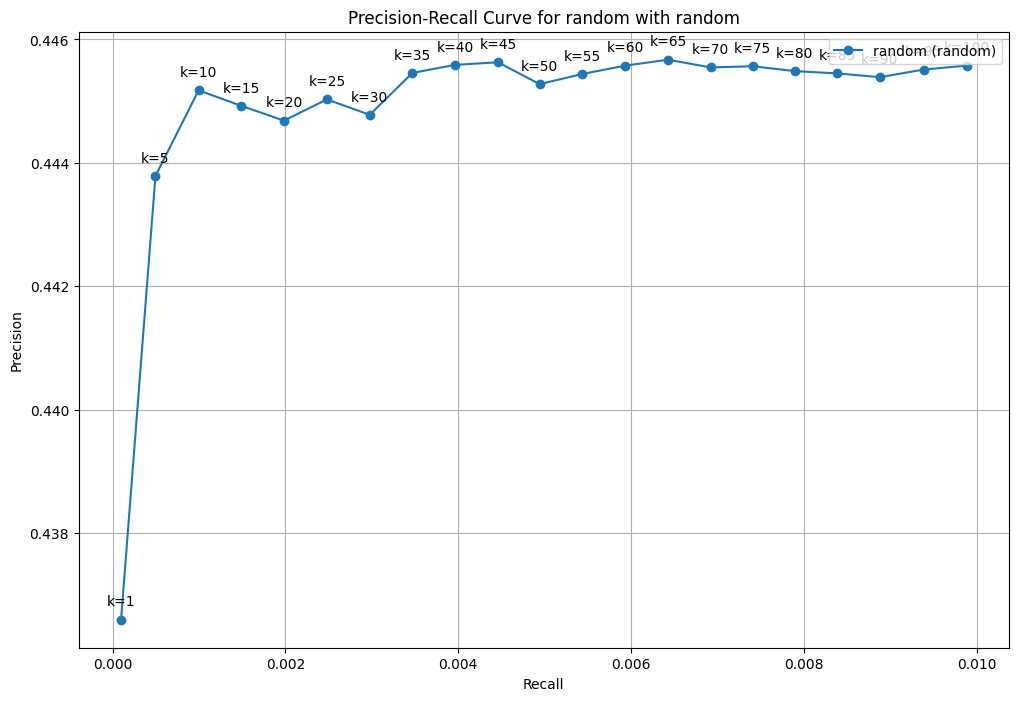

Calculating metrics for cosine with tf-idf...


  0%|          | 0/10094 [00:00<?, ?it/s]

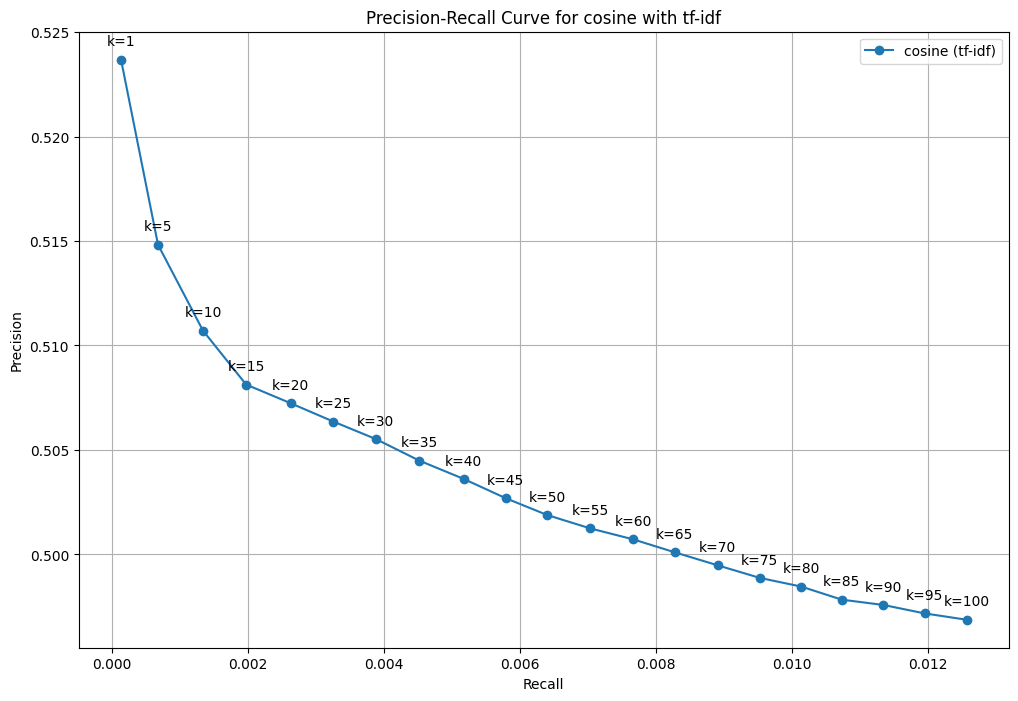

Calculating metrics for cosine with bert...


  0%|          | 0/10094 [00:00<?, ?it/s]

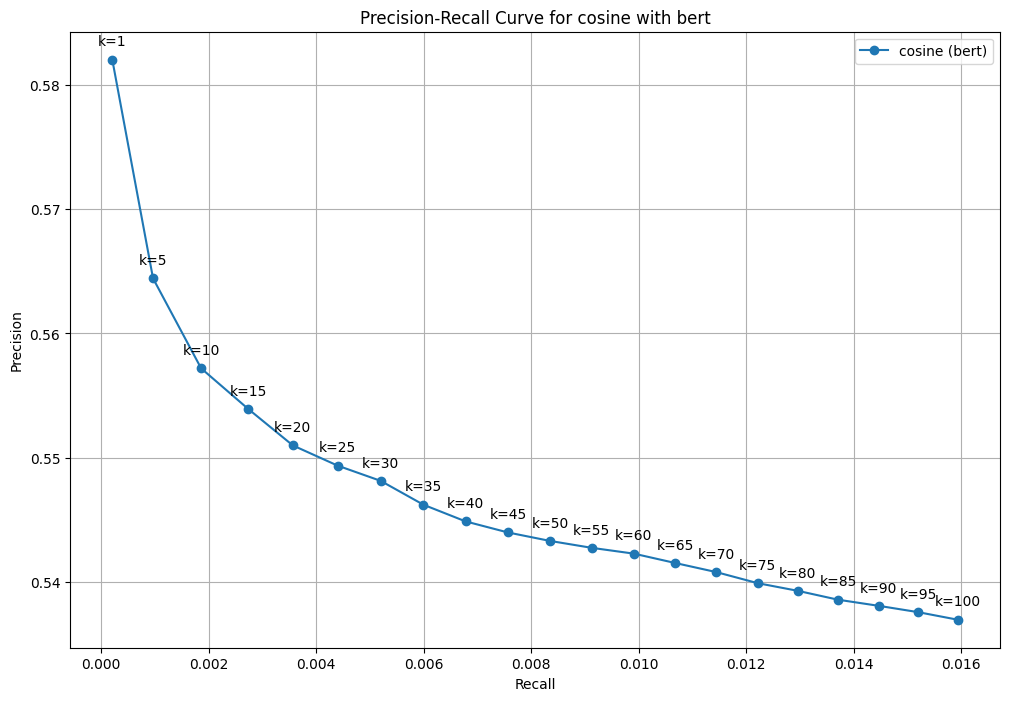

Calculating metrics for dot with word2vec...


  0%|          | 0/10094 [00:00<?, ?it/s]

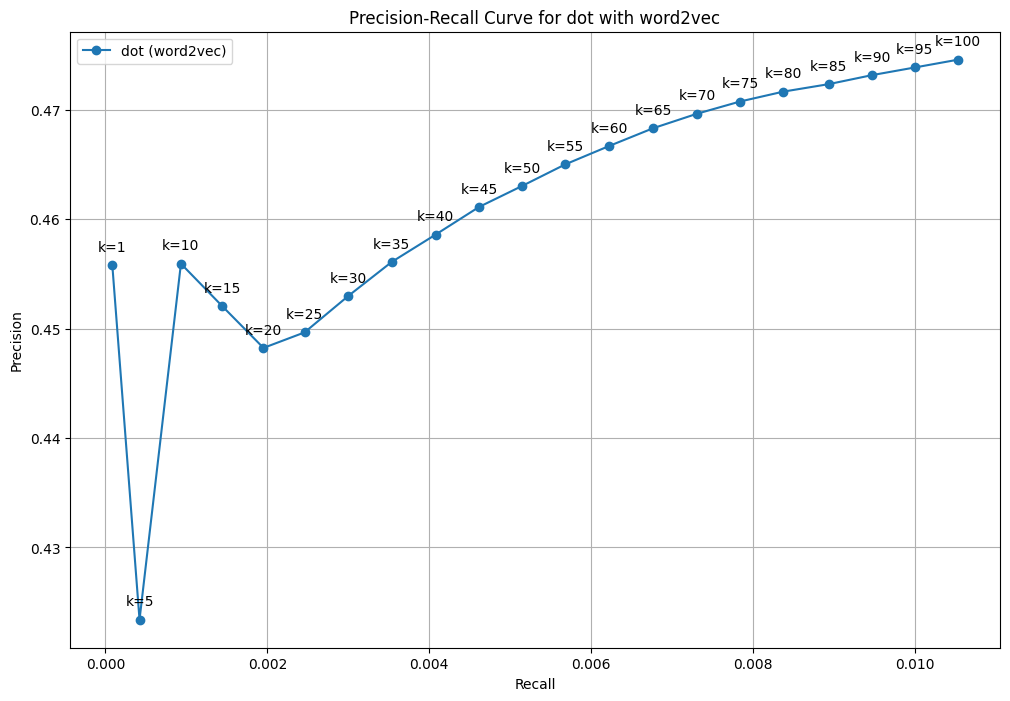

Calculating metrics for cosine with mfcc_bow...


  0%|          | 0/10094 [00:00<?, ?it/s]

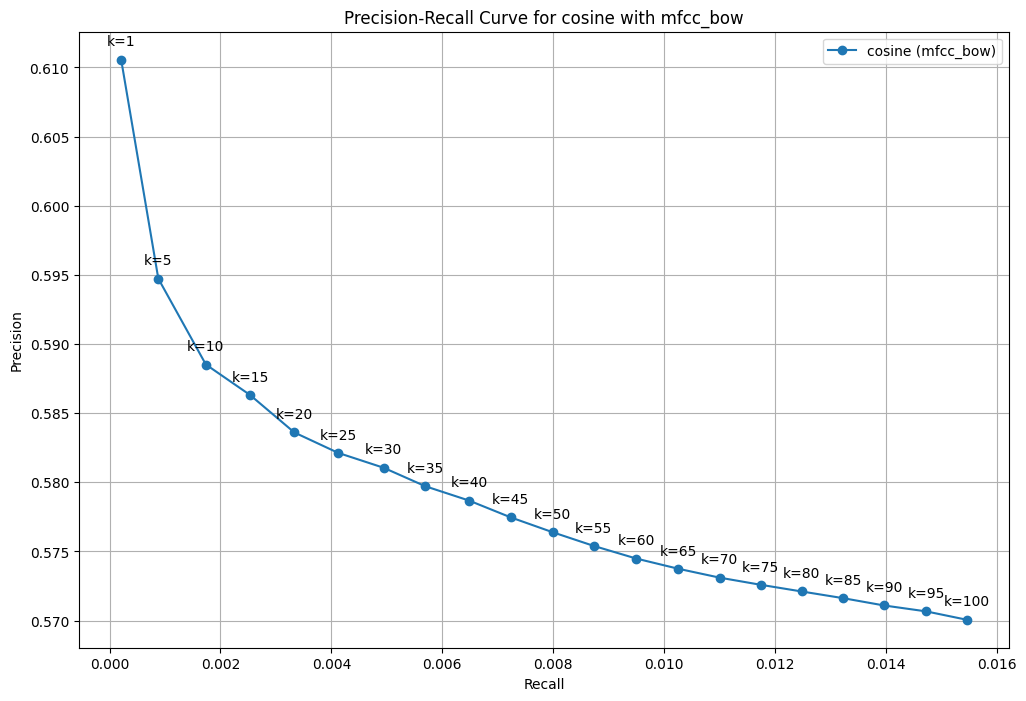

Calculating metrics for cosine with blf_spectral...


  0%|          | 0/10094 [00:00<?, ?it/s]

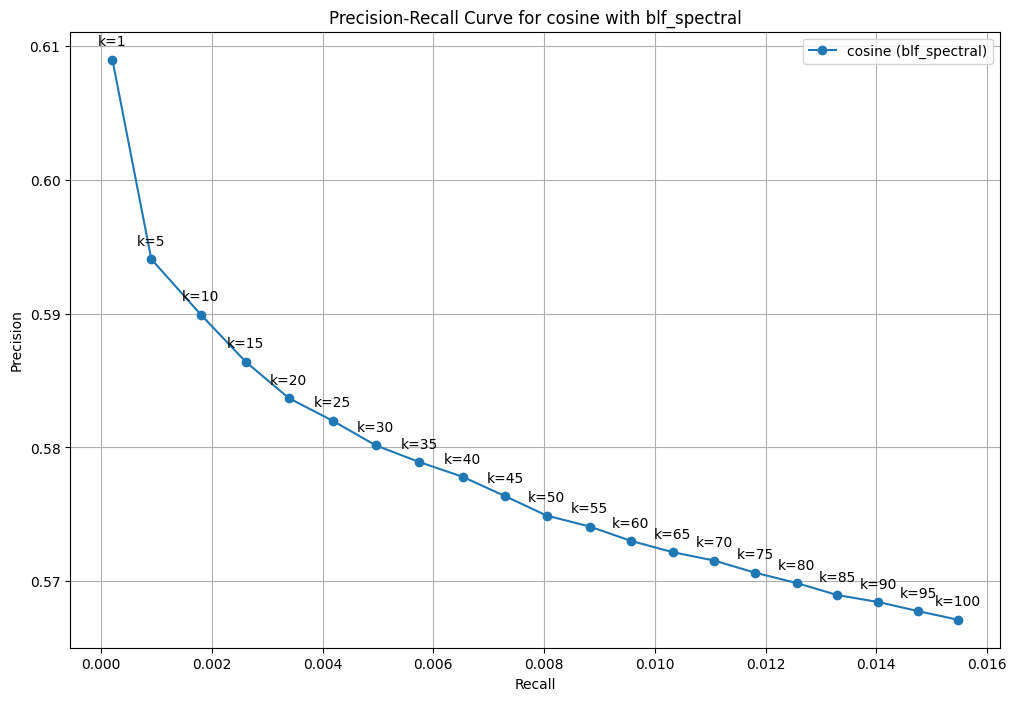

Calculating metrics for cosine with ivec256...


  0%|          | 0/10094 [00:00<?, ?it/s]

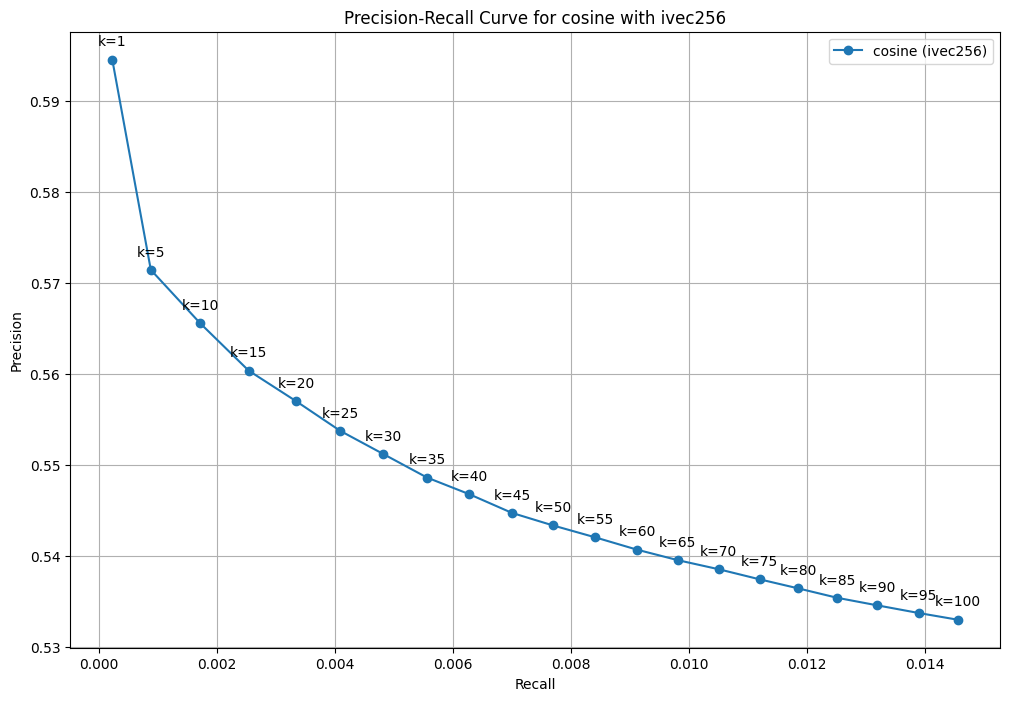

Calculating metrics for cosine with musicnn...


  0%|          | 0/10094 [00:00<?, ?it/s]

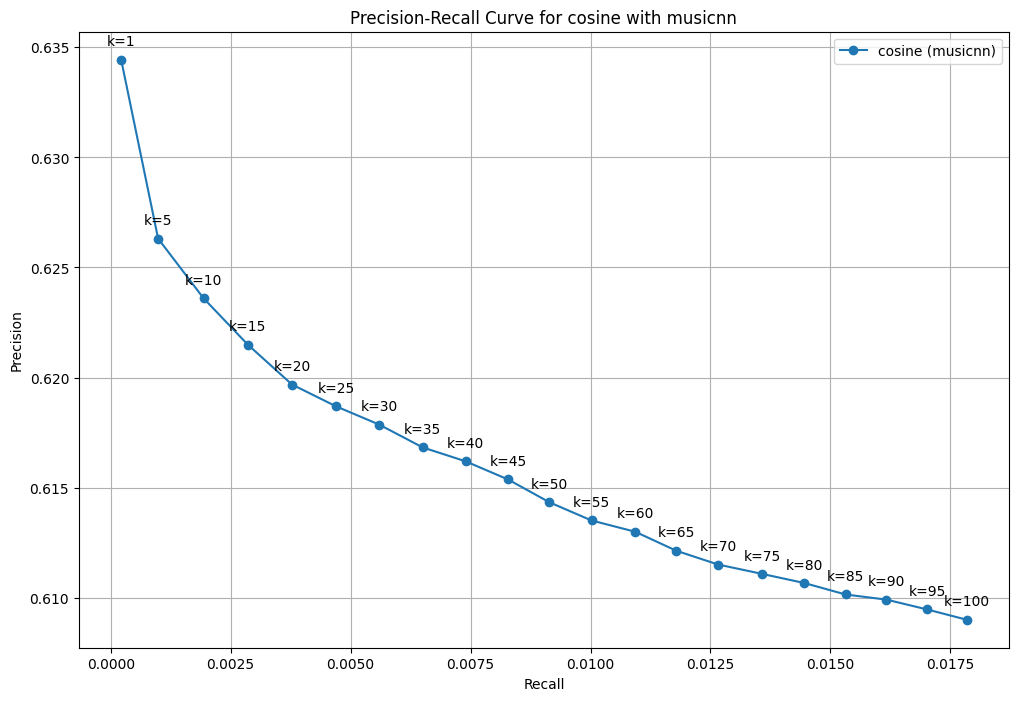

In [45]:
rs["metrics"] = None

for index, row in rs.iterrows():
    rs_object = row["rs_object"]
    metric_name = row["metric"]
    feature_name = row["feature"]
    print(f"Calculating metrics for {metric_name} with {feature_name}...")

    # Calculate metrics
    metrics_df = calc_metrics(rs_object, k1=K1, k2=K2, step=STEP)

    # Store the metrics DataFrame in the rs DataFrame
    rs.at[index, "metrics"] = metrics_df

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(
        metrics_df["recall"],
        metrics_df["precision"],
        marker="o",
        label=f"{metric_name} ({feature_name})",
    )

    # Annotate each point with its k value
    for k, recall, precision in zip(
        metrics_df.index, metrics_df["recall"], metrics_df["precision"]
    ):
        plt.annotate(
            f"k={k}",
            (recall, precision),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
        )

    plt.title(f"Precision-Recall Curve for {metric_name} with {feature_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
rs.to_csv("task_2.csv", index=False)

In [54]:
# rs = pd.read_csv("task_2.csv")

In [55]:
rs

,metric,feature,rs_object,mean_precision_at_k,mean_recall_at_k,precision_and_recall_interval,mean_ndcg_at_k,genre_coverage_at_k,mean_genre_diversity_at_k
0,random,random,<task1.retrieval_system.RetrievalSystem object...,0.442520,0.000976,recall precision\nk ...,0.131709,1.000000,NaN
1,cosine,tf-idf,<task1.retrieval_system.RetrievalSystem object...,0.510709,0.001340,recall precision\nk ...,0.163754,0.982014,4.974558
2,cosine,bert,<task1.retrieval_system.RetrievalSystem object...,0.557192,0.001862,recall precision\nk ...,0.196265,0.956835,4.845966
3,dot,word2vec,<task1.retrieval_system.RetrievalSystem object...,0.455934,0.000933,recall precision\nk ...,0.124160,0.480216,4.681670
4,cosine,mfcc_bow,<task1.retrieval_system.RetrievalSystem object...,0.588518,0.001737,recall precision\nk ...,0.216050,0.981115,4.743527
5,cosine,blf_spectral,<task1.retrieval_system.RetrievalSystem object...,0.589935,0.001800,recall precision\nk ...,0.218365,0.972122,4.737670
6,cosine,ivec256,<task1.retrieval_system.RetrievalSystem object...,0.565564,0.001712,recall precision\nk ...,0.208839,0.999101,4.905104
7,cosine,musicnn,<task1.retrieval_system.RetrievalSystem object...,0.623598,0.001937,recall precision\nk ...,0.231601,0.997302,4.705990


## Analysis

### Precision & Recall

In [ ]:
rs["precision_and_recall_interval"][0]

'      recall  precision\nk                      \n95  0.009350   0.445063\n90  0.008860   0.444976\n85  0.008365   0.445046\n80  0.007875   0.445097\n75  0.007375   0.445138\n70  0.006897   0.445259\n65  0.006396   0.445241\n60  0.005910   0.445094\n55  0.005419   0.445111\n50  0.004937   0.445259\n45  0.004443   0.445045\n40  0.003933   0.444814\n35  0.003439   0.444977\n30  0.002952   0.445119\n25  0.002452   0.444882\n20  0.001951   0.444170\n15  0.001467   0.443597\n10  0.000976   0.442520\n5   0.000494   0.441649\n1   0.000105   0.440757'

In [ ]:
import re


def parse_precision_recall_data(text: str) -> pd.DataFrame:
    """Function to parse the precision and recall interval data after saving to csv.

    Args:
        text (str): The text to parse.

    Returns:
        pd.DataFrame: DataFrame containing the parsed data.
    """
    # Splitting the text into lines and removing empty lines
    lines = [line.strip() for line in text.split("\n") if line.strip()]

    # Extracting data from each line
    data = []
    for line in lines[1:]:  # Skipping the header line
        match = re.match(r"(\d+)\s+([\d.]+)\s+([\d.]+)", line)
        if match:
            k = int(match.group(1))
            recall = float(match.group(2))
            precision = float(match.group(3))
            data.append((k, recall, precision))

    return pd.DataFrame(data, columns=["k", "recall", "precision"])

In [ ]:
parse_precision_recall_data(rs["precision_and_recall_interval"][0])

,k,recall,precision
0,95,0.009350,0.445063
1,90,0.008860,0.444976
2,85,0.008365,0.445046
3,80,0.007875,0.445097
4,75,0.007375,0.445138
5,70,0.006897,0.445259
6,65,0.006396,0.445241
7,60,0.005910,0.445094
8,55,0.005419,0.445111
9,50,0.004937,0.445259


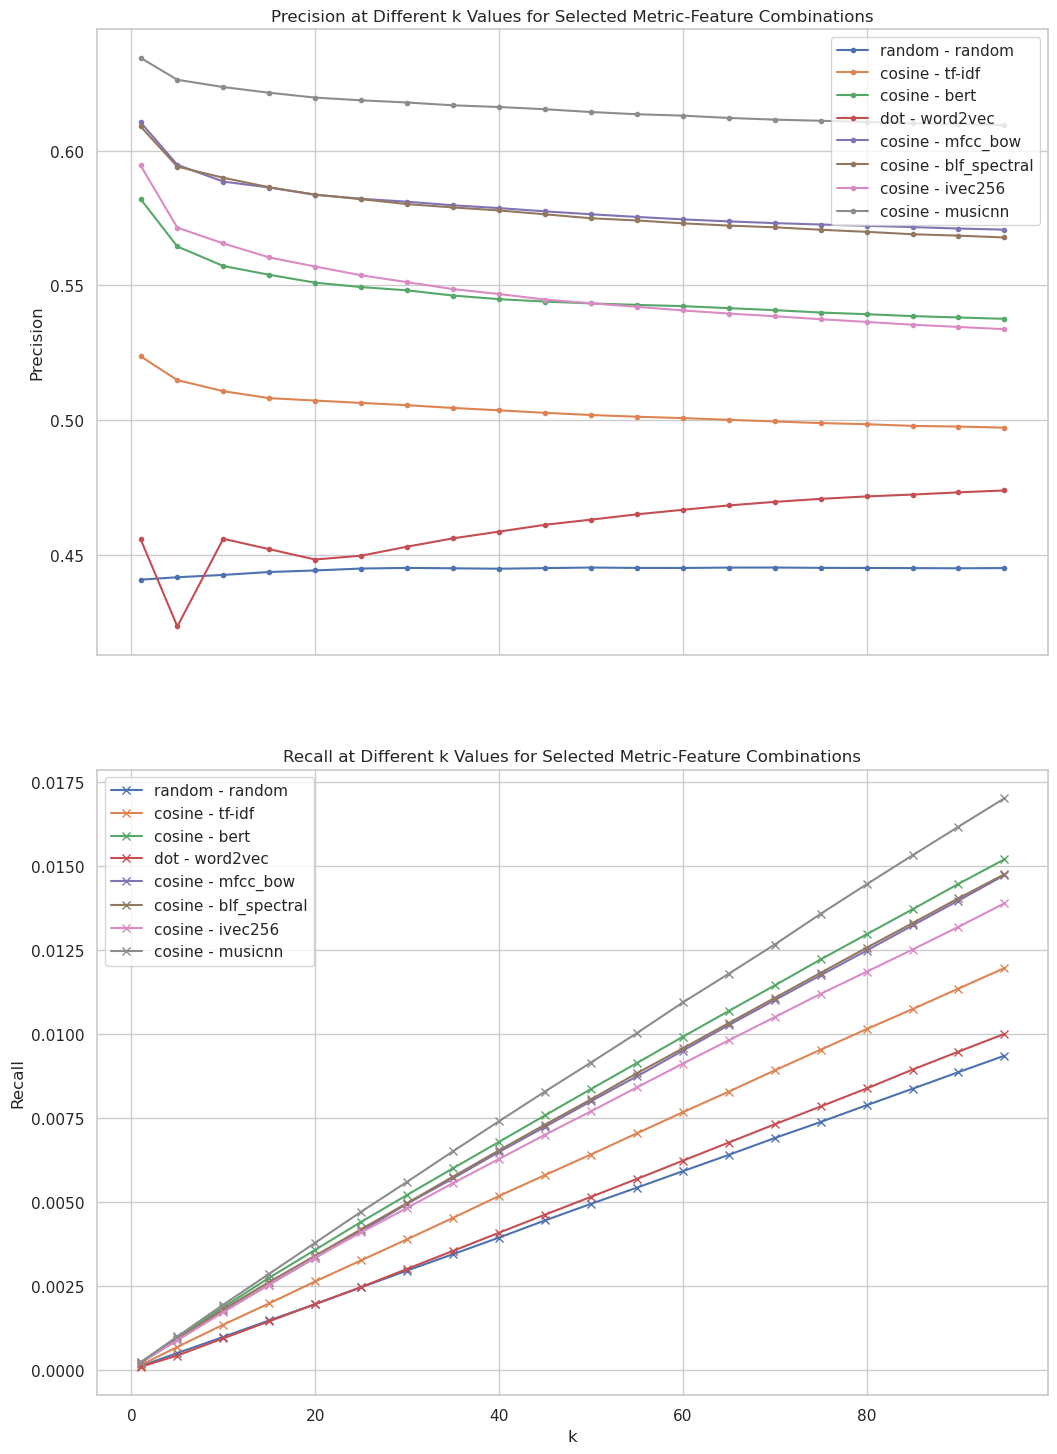

In [105]:
# Selecting a few retrieval systems for plotting
selected_rs_objects = rs["rs_object"]  # .unique()[:4]

# Create separate plots for precision and recall for selected metric-feature combinations
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 16), sharex=True)
fig.tight_layout(pad=6.0)

for rs_object in selected_rs_objects:
    row_data = rs[rs["rs_object"] == rs_object].iloc[0]
    parsed_data = parse_precision_recall_data(row_data["precision_and_recall_interval"])

    legend_label = f'{row_data["metric"]} - {row_data["feature"]}'

    axes[0].plot(
        parsed_data["k"], parsed_data["precision"], marker=".", label=legend_label
    )
    axes[1].plot(
        parsed_data["k"], parsed_data["recall"], marker="x", label=legend_label
    )

axes[0].set_title(
    "Precision at Different k Values for Selected Metric-Feature Combinations"
)
axes[0].set_ylabel("Precision")
axes[0].legend()

axes[1].set_title(
    "Recall at Different k Values for Selected Metric-Feature Combinations"
)
axes[1].set_xlabel("k")
axes[1].set_ylabel("Recall")
axes[1].legend()

plt.show()

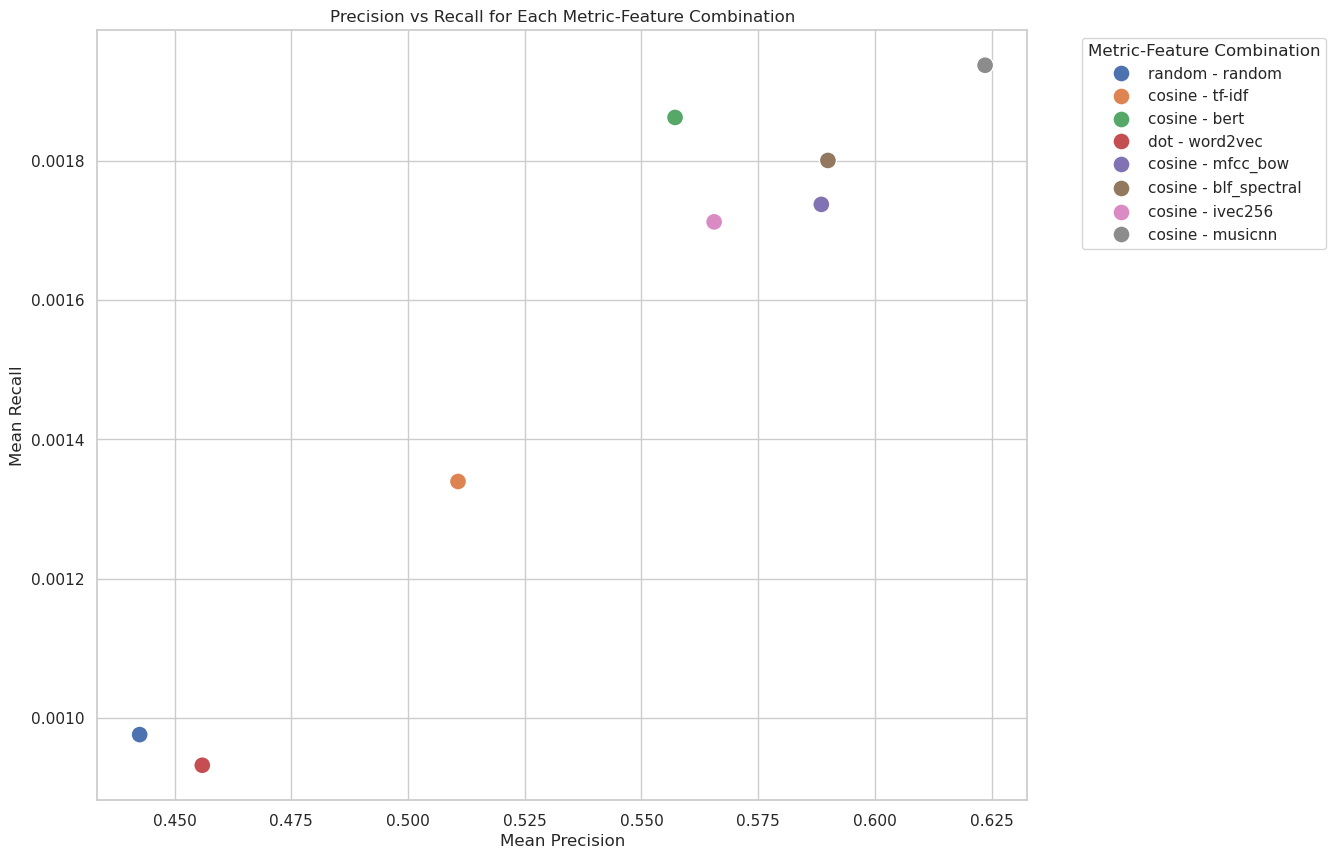

In [98]:
rs["metric_feature_combination"] = rs["metric"] + " - " + rs["feature"]

plt.figure(figsize=(12, 10))
sns.scatterplot(
    x="mean_precision_at_k",
    y="mean_recall_at_k",
    hue="metric_feature_combination",
    data=rs,
    s=150,
)
plt.title("Precision vs Recall for Each Metric-Feature Combination")
plt.xlabel("Mean Precision")
plt.ylabel("Mean Recall")
plt.legend(
    title="Metric-Feature Combination", bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.show()

In [72]:
rs[
    [
        "mean_precision_at_k",
        "mean_recall_at_k",
        "mean_ndcg_at_k",
        "genre_coverage_at_k",
        "mean_genre_diversity_at_k",
    ]
].describe()

,mean_precision_at_k,mean_recall_at_k,mean_ndcg_at_k,genre_coverage_at_k,mean_genre_diversity_at_k
count,8.000000,8.000000,8.000000,8.000000,7.000000
mean,0.541746,0.001537,0.186343,0.921088,4.799212
std,0.065670,0.000401,0.041270,0.178761,0.110710
min,0.442520,0.000933,0.124160,0.480216,4.681670
25%,0.497016,0.001249,0.155743,0.968300,4.721830
50%,0.561378,0.001725,0.202552,0.981565,4.743527
75%,0.588872,0.001816,0.216628,0.997752,4.875535
max,0.623598,0.001937,0.231601,1.000000,4.974558


### Simple barplot

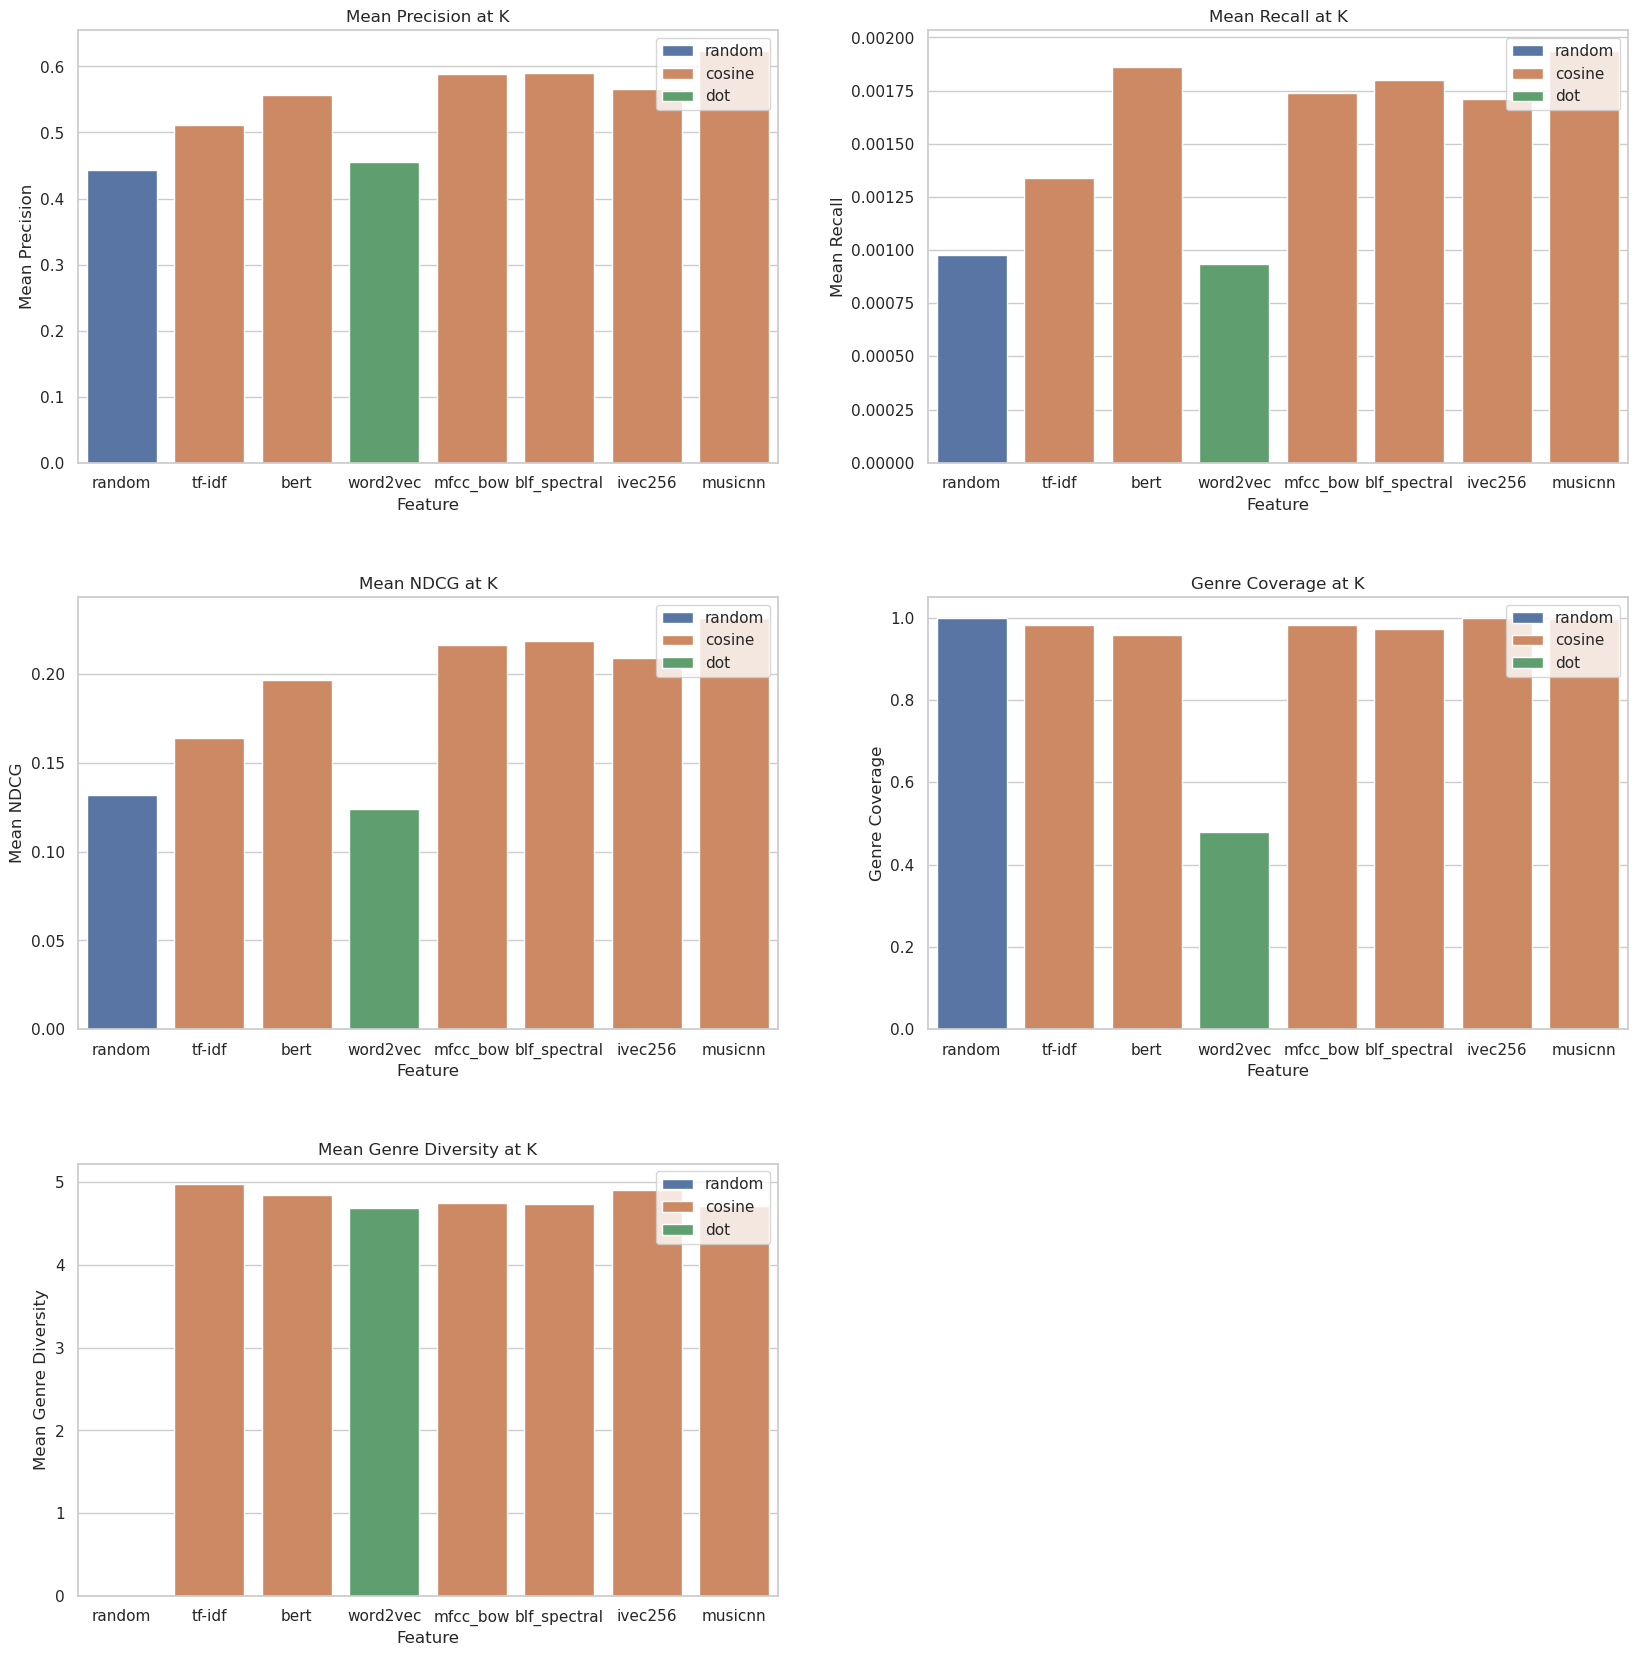

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
fig.tight_layout(pad=6.0)

sns.barplot(y="mean_precision_at_k", x="feature", hue="metric", data=rs, ax=axes[0, 0])
axes[0, 0].set_title("Mean Precision at K")
axes[0, 0].set_ylabel("Mean Precision")
axes[0, 0].set_xlabel("Feature")

sns.barplot(y="mean_recall_at_k", x="feature", hue="metric", data=rs, ax=axes[0, 1])
axes[0, 1].set_title("Mean Recall at K")
axes[0, 1].set_ylabel("Mean Recall")
axes[0, 1].set_xlabel("Feature")

sns.barplot(y="mean_ndcg_at_k", x="feature", hue="metric", data=rs, ax=axes[1, 0])
axes[1, 0].set_title("Mean NDCG at K")
axes[1, 0].set_ylabel("Mean NDCG")
axes[1, 0].set_xlabel("Feature")

sns.barplot(y="genre_coverage_at_k", x="feature", hue="metric", data=rs, ax=axes[1, 1])
axes[1, 1].set_title("Genre Coverage at K")
axes[1, 1].set_ylabel("Genre Coverage")
axes[1, 1].set_xlabel("Feature")

sns.barplot(
    y="mean_genre_diversity_at_k", x="feature", hue="metric", data=rs, ax=axes[2, 0]
)
axes[2, 0].set_title("Mean Genre Diversity at K")
axes[2, 0].set_ylabel("Mean Genre Diversity")
axes[2, 0].set_xlabel("Feature")

axes[0, 0].legend(loc="upper right")
axes[0, 1].legend(loc="upper right")
axes[1, 0].legend(loc="upper right")
axes[1, 1].legend(loc="upper right")
axes[2, 0].legend(loc="upper right")

# hide empty subplot (6th one)
axes[2, 1].set_visible(False)

plt.show()

### Histogram

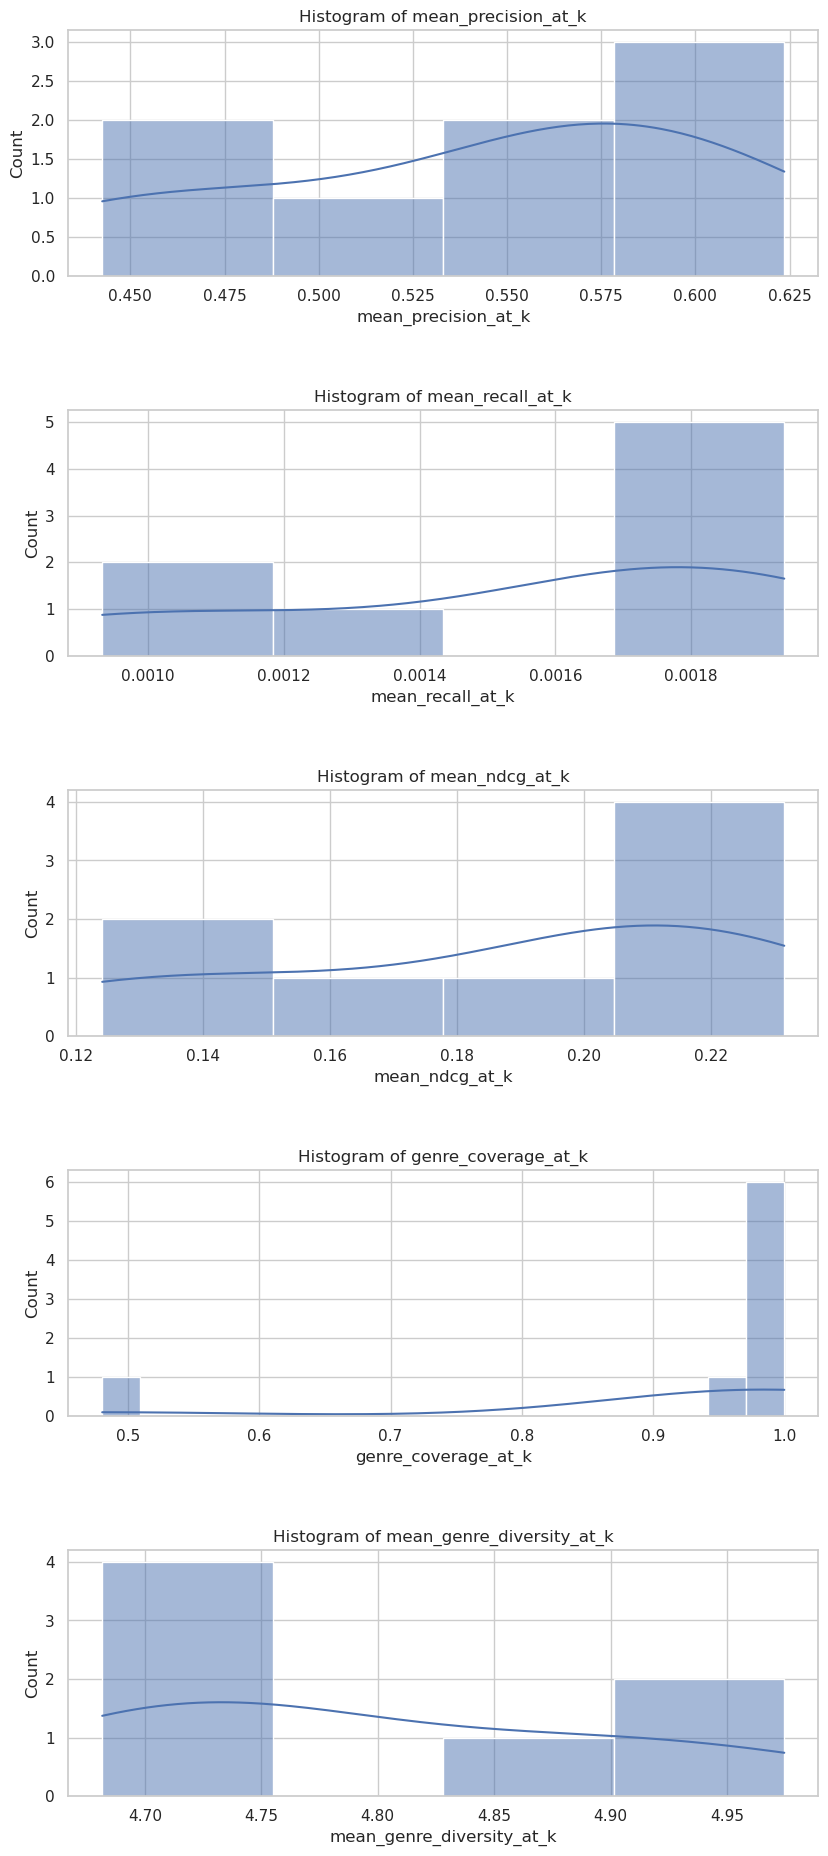

In [88]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
fig.tight_layout(pad=6.0)

for i, metric in enumerate(metrics_list):
    sns.histplot(rs[metric], kde=True, ax=axes[i])
    axes[i].set_title(f"Histogram of {metric}")

plt.show()

### Metric Correlation

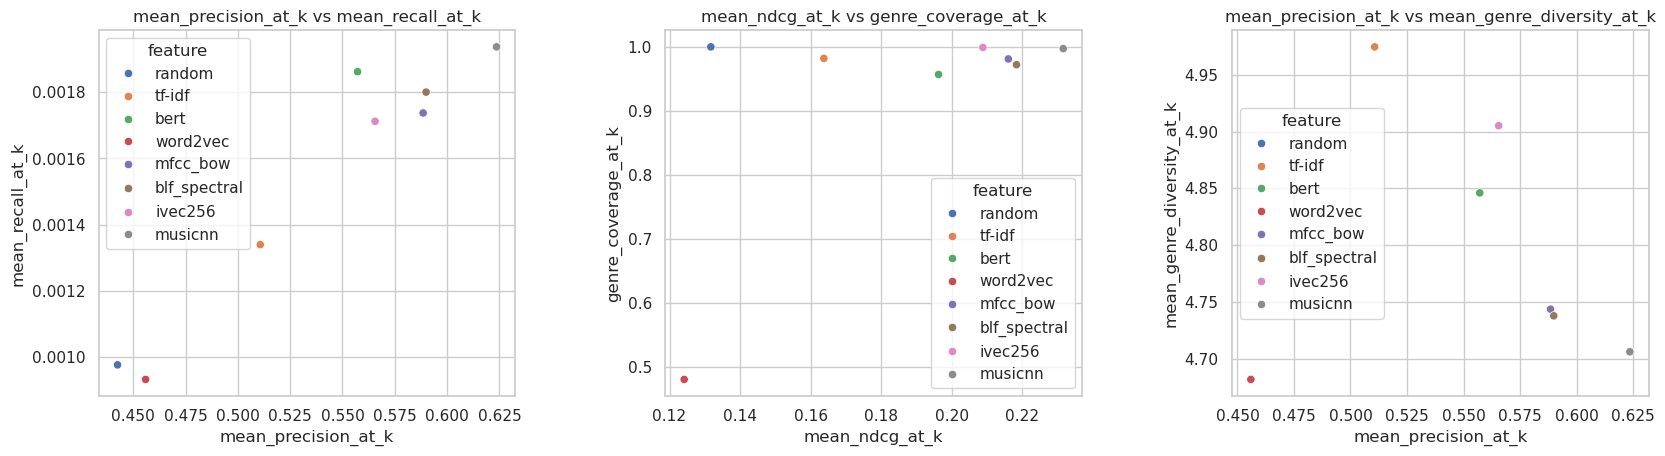

In [ ]:
# Scatter plots for metric pairings
# Selecting a few interesting pairs of metrics
pairs = [
    ("mean_precision_at_k", "mean_recall_at_k"),
    ("mean_ndcg_at_k", "genre_coverage_at_k"),
    ("mean_precision_at_k", "mean_genre_diversity_at_k"),
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.tight_layout(pad=6.0)

for i, (metric1, metric2) in enumerate(pairs):
    sns.scatterplot(x=metric1, y=metric2, hue="feature", data=rs, ax=axes[i])
    axes[i].set_title(f"{metric1} vs {metric2}")

plt.show()

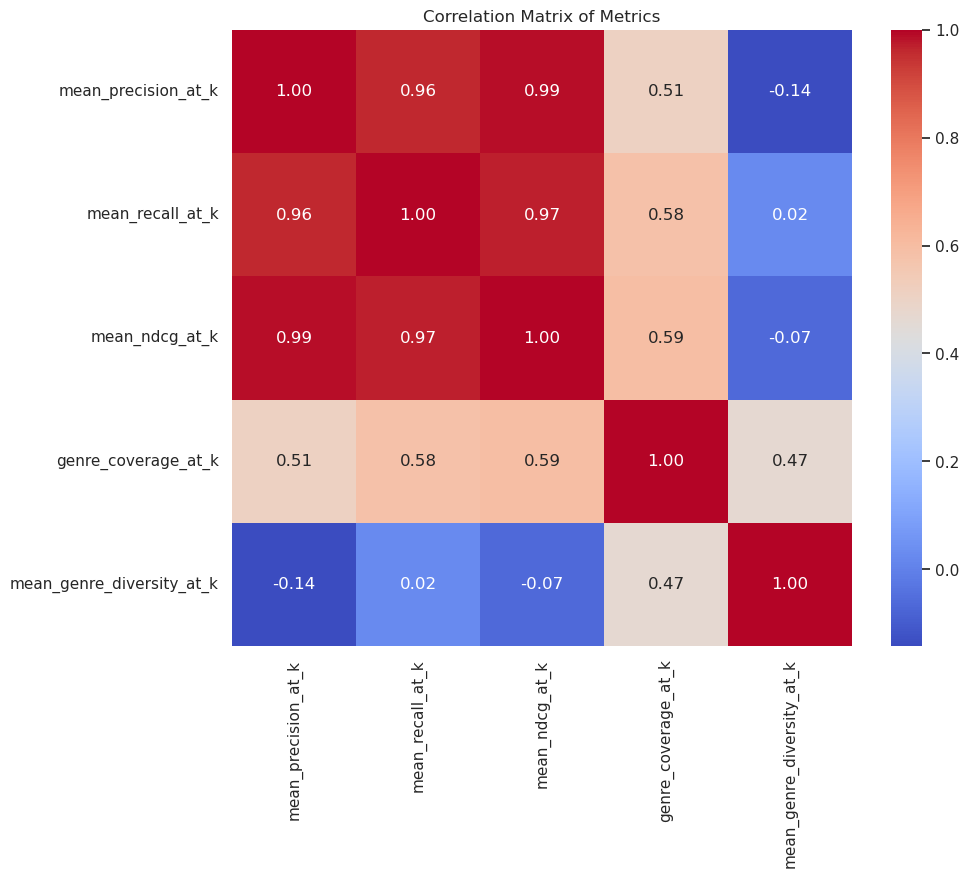

In [78]:
correlation_matrix = rs[
    [
        "mean_precision_at_k",
        "mean_recall_at_k",
        "mean_ndcg_at_k",
        "genre_coverage_at_k",
        "mean_genre_diversity_at_k",
    ]
].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Metrics")
plt.show()

In [112]:
rs_show = rs.drop(
    columns=[
        "rs_object",
        "metric_feature_combination",
        "precision_and_recall_interval",
    ],
    axis=1,
)

In [113]:
rs_show

,metric,feature,mean_precision_at_k,mean_recall_at_k,mean_ndcg_at_k,genre_coverage_at_k,mean_genre_diversity_at_k
0,random,random,0.442520,0.000976,0.131709,1.000000,NaN
1,cosine,tf-idf,0.510709,0.001340,0.163754,0.982014,4.974558
2,cosine,bert,0.557192,0.001862,0.196265,0.956835,4.845966
3,dot,word2vec,0.455934,0.000933,0.124160,0.480216,4.681670
4,cosine,mfcc_bow,0.588518,0.001737,0.216050,0.981115,4.743527
5,cosine,blf_spectral,0.589935,0.001800,0.218365,0.972122,4.737670
6,cosine,ivec256,0.565564,0.001712,0.208839,0.999101,4.905104
7,cosine,musicnn,0.623598,0.001937,0.231601,0.997302,4.705990


In [116]:
rs_show.to_latex(
    "task_2_table.tex", index=False, float_format="%.3f", column_format="llccccc"
)